## 7.

In [26]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [72]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris= True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)      #  0 <= X <= 7.5 범위에서 포인트 100개 추출
    x2s = np.linspace(axes[2], axes[3], 100)      #  0 <= Y <= 3.0 범위에서 포인트 100개 추출
    x1, x2 = np.meshgrid(x1s, x2s)                #  격자 생성 
    X_new = np.c_[x1.ravel(), x2.ravel()]         # 100 x 100 좌표
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0','red', 'green', 'blue'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)

# if plot_training, if iris 만 사용됨
    if not iris:    # 왜 사용하는 걸까?
       custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50', 'red', 'green', 'blue'])
       # custom_cmap2 = ListedColormap(['red','green','blue']) 
       plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=1.0, linewidths = 5)
    if plot_training:       
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa", alpha = 0.3, markersize = 1)
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor", alpha = 0.3, markersize = 1)
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica", alpha = 0.3, markersize = 1)
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

_문제: moons 데이터셋에 결정 트리를 훈련시키고 세밀하게 튜닝해보세요._

a. `make_moons(n_samples=1000, noise=0.4)`를 사용해 데이터셋을 생성합니다.

`random_state=42`를 지정하여 결과를 일정하게 만듭니다:

In [30]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

In [3]:
X.shape, y.shape

((10000, 2), (10000,))

In [4]:
type(X), type(y), X[0:5,:], y[0:5]

(numpy.ndarray,
 numpy.ndarray,
 array([[ 0.9402914 ,  0.12230559],
        [ 0.12454026, -0.42477546],
        [ 0.26198823,  0.50841438],
        [-0.49523824,  0.07258876],
        [-0.87941281,  0.54937303]]),
 array([1, 0, 0, 0, 0], dtype=int64))

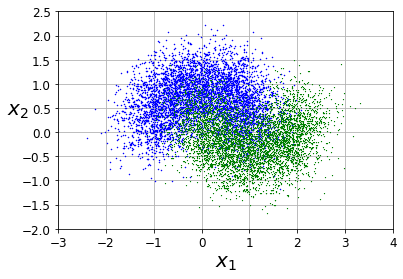

In [40]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", markersize = 0.5)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^",  markersize = 0.5)
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-3, 4, -2, 2.5])
plt.show()

b. 이를 `train_test_split()`을 사용해 훈련 세트와 테스트 세트로 나눕니다.  

- test_size = 0.2 설정

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8000, 2), (8000,), (2000, 2), (2000,))

c. `DecisionTreeClassifier`의 최적의 매개변수를 찾기 위해 교차 검증과 함께 그리드 탐색을 수행합니다  
(`GridSearchCV`를 사용하면 됩니다). 힌트: 여러 가지 `max_leaf_nodes` 값을 시도해보세요.

- 규제매개변수: 트리의 자유도(성장)을 제한하는 매개 변수
    - **max_depth: 깊이 조정, 루트 노드 0, 디폴트 None**
    - **min_samples_split: 분할되기 위해 노드의 최소 샘플수, 설정값 이하이면 분할 중단** 
    - **min_samples_leaf: leaf 노드가 가져야할 최소 샘플**    
    - min_weight_fraction_leaf: min_samples_leaf와 동일하나 전체 샘플에서 비율
    - **max_leaf_nodes: leaf 노드의 최대수**
    - max_features: 분할에 사용되는 특성의 최대수
    

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}     # 98 * 3 = 294개 후보 하이퍼 파라미터
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)  # total fitting 294 * 3 = 882 

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [22]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=17, random_state=42)

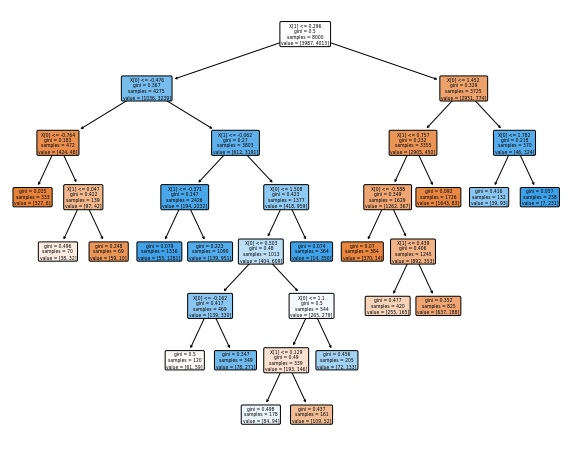

In [23]:
# plot tree
from sklearn.tree import plot_tree

make_moon_clf = DecisionTreeClassifier(max_leaf_nodes=17, random_state=42)
make_moon_clf.fit(X_train, y_train)

plt.figure(figsize=(10,8))
plot_tree(make_moon_clf,
          filled = True,
          rounded = True)
plt.show()

C:\Users\edmin\AppData\Local\Temp\ipykernel_33948\2091465081.py:16: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=1.0, linewidth = 2.5)


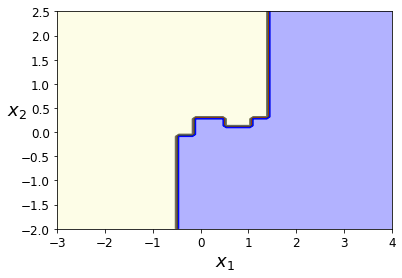

In [71]:
plot_decision_boundary(make_moon_clf, X_train, y_train, axes=[-3, 4, -2, 2.5], iris= False, legend=False, plot_training=False)

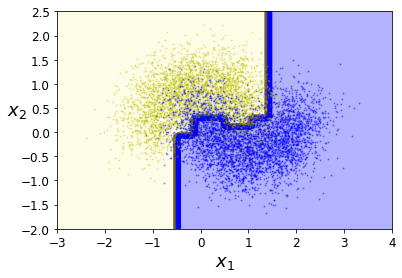

In [74]:
plot_decision_boundary(make_moon_clf, X_train, y_train, axes=[-3, 4, -2, 2.5], iris= False) 
# alpha = 0.3, markersize = 2, linewidths = 5

d. 찾은 매개변수를 사용해 전체 훈련 세트에 대해 모델을 훈련시키고 테스트 세트에서 성능을 측정합니다. 대략 85~87%의 정확도가 나올 것입니다.

기본적으로 `GridSearchCV`는 전체 훈련 세트로 찾은 최적의 모델을 다시 훈련시킵니다(`refit=False`로 지정해서 바꿀 수 있습니다). 그래서 별도로 작업할 필요가 없습니다. 모델의 정확도를 바로 평가할 수 있습니다:

In [17]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8695

In [26]:
#2. GridSearchCV에 max_depth 추가 ==> 결론적으로 좀 더 단순한 모델로 유사한 정확율 도출 가능

from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4], 'max_depth':[2,3,4,5]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 1176 candidates, totalling 3528 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [2, 3, 4, 5],
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [27]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_depth=2, max_leaf_nodes=4, random_state=42)

In [28]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.863

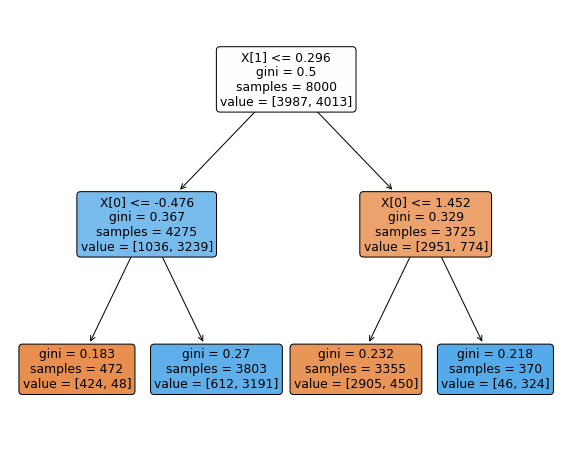

In [30]:
from sklearn.tree import plot_tree

make_moon_clf = DecisionTreeClassifier(max_depth=2, max_leaf_nodes=4, random_state=42)
make_moon_clf.fit(X_train, y_train)

plt.figure(figsize=(10,8))
plot_tree(make_moon_clf,
          filled = True,
          rounded = True)
plt.show()

In [29]:
# 3. GridSearchCV에 max_depth만 사용하는 경우 (위 2와 동일함)

from sklearn.model_selection import GridSearchCV

params = {'max_depth': list(range(2, 10))}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9]}, verbose=1)

In [30]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_depth=2, random_state=42)

In [31]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.863

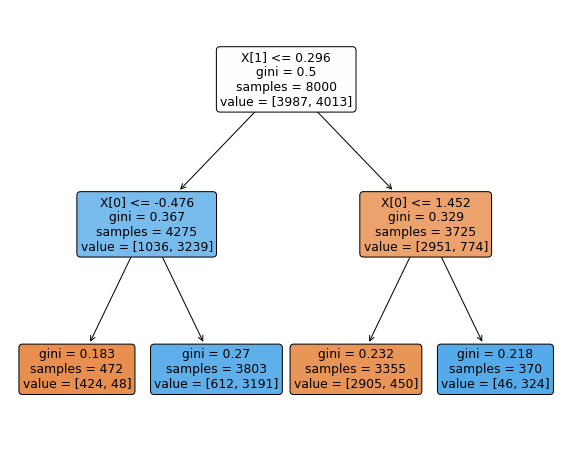

In [32]:
from sklearn.tree import plot_tree

make_moon_clf3 = DecisionTreeClassifier(max_depth=2, random_state=42)
make_moon_clf3.fit(X_train, y_train)

plt.figure(figsize=(10,8))
plot_tree(make_moon_clf3,
          filled = True,
          rounded = True)
plt.show()

In [41]:
make_moon_clf3.cost_complexity_pruning_path(X_train, y_train)

{'ccp_alphas': array([0.        , 0.04581271, 0.05707611, 0.15046701]),
 'impurities': array([0.2466389 , 0.2924516 , 0.34952771, 0.49999472])}

### 가지치기 알고리즘: minimal cost-complexity pruning

- 과대 적합(Overfitting)을 방지하기 위하여  $\alpha (\ge 0, \text{complexity parameter})$ 를 매개변수화하는 알고리즘
- Tree T의 cost-complexity $R_\alpha(T)$ 정의
    
    $R_\alpha(T) = R(T) + \alpha \lvert \tilde{T} \rvert$
    
    $R(T)$      : 오분류률(misclassification rate)  
    $\tilde{T}$ : 단말(Ternimal) 노드 수
    
- cost-complexity $R_\alpha(T)$를 최소화하는 subtree T를 찾아 가지치기 함
- 상위노드(루트/부모노드, t 노드) $t$ 에서의 불순율은 일반적으로 자식노드 $T_t$에서의 불순율 합보다 크지만  
   $(R(t) \ge R(T_t))$ ,complexity parameter $\alpha$ 의 값에 따라 같아 질수 있음. 이 $\alpha$를 $\alpha_{eff}$라고함
    
    $$
    \begin{align}
    R_\alpha(t) &= R(t) + \alpha \\ R_\alpha(T_t) &= R(T_t) + \alpha \lvert T \rvert \\ R_\alpha(t) &= R_\alpha(T_t) \\ \therefore R(t) + \alpha &= R(T_t) + \alpha \lvert T \rvert \\ \alpha_{eff} &= \frac{R(t) - R(T_t)}{\lvert T \rvert - 1} 
    \end{align}
    $$
    
- 가장 작은 $\alpha_{eff}$를 가지는 (단말노드가 아닌)노드가 가장 약하고 가지치기 대상이 되는 노드임
- $\alpha_{eff} \ge$ `ccp_alpha`  이면 가지치기 중단함

Minimal Cost-Complexity Pruning:  <https://scikit-learn.org/stable/modules/tree.html#bre>  

과적합 방지: https://runebook.dev/ko/docs/scikit_learn/auto_examples/tree/plot_cost_complexity_pruning

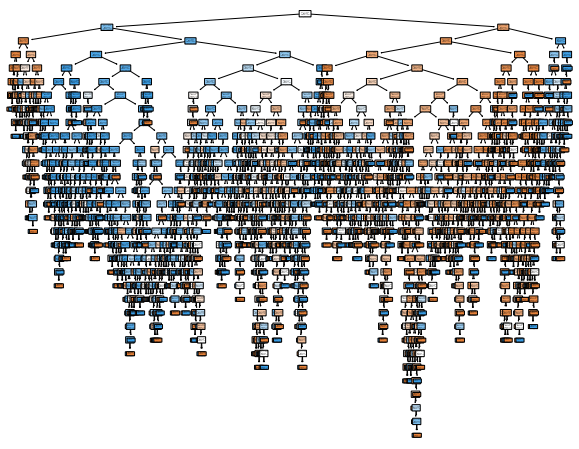

In [35]:
# 최대적합
from sklearn.tree import plot_tree

make_moon_clf_inf = DecisionTreeClassifier(random_state=42)
make_moon_clf_inf.fit(X_train, y_train)

plt.figure(figsize=(10,8))
plot_tree(make_moon_clf_inf,
          filled = True,
          rounded = True)
plt.show()

In [45]:
make_moon_clf_inf.get_depth()  # 31 depth

31

In [43]:
make_moon_clf_inf.get_n_leaves() # 1274개 단말 노드

1274

In [46]:
# ccp_alpha, impurity 도출
tree_path = make_moon_clf_inf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = tree_path.ccp_alphas, tree_path.impurities

In [49]:
len(ccp_alphas)  # 결과 469개의 가지치기 후보 노드가 있음

469

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

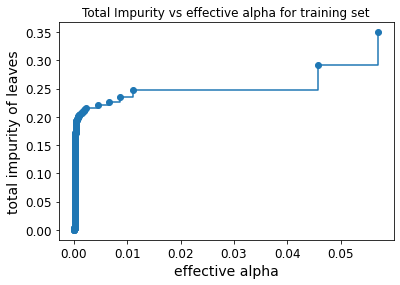

In [51]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [48]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.1504670096562365


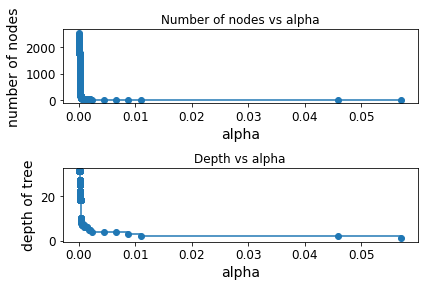

In [53]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

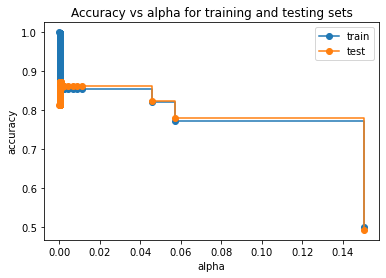

In [50]:
train_scores = [make_moon_clf_inf.score(X_train, y_train) for make_moon_clf_inf in clfs]
test_scores = [make_moon_clf_inf.score(X_test, y_test) for make_moon_clf_inf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [55]:
# ccp_alpha 0.01, 0.015에서 fitting 및 score 보기
clf0010 = DecisionTreeClassifier(random_state=42, ccp_alpha=0.01)
clf0015 = DecisionTreeClassifier(random_state=42, ccp_alpha=0.015)

clf0010.fit(X_train, y_train)
clf0015.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.015, random_state=42)

In [57]:
clf0010.get_depth(), clf0015.get_depth()

(3, 2)

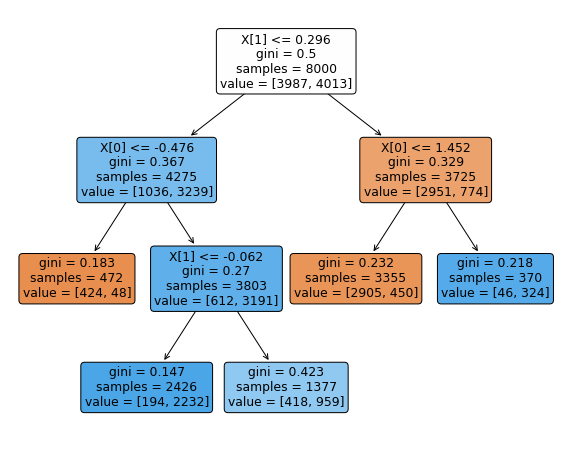

In [61]:
plt.figure(figsize=(10,8))
plot_tree(clf0010,
          filled = True,
          rounded = True)
plt.show()

In [62]:
y_pred = clf0010.predict(X_test)
accuracy_score(y_test, y_pred)

0.863

In [63]:
y_pred = clf0015.predict(X_test)
accuracy_score(y_test, y_pred)

0.863

ccp_alpha 0.01과 0.015의 tree는 다르지만 accuracy_score는 동일함